In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.kuka.reaching import KukaReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/kuka/'

In [5]:
task = KukaReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100 * torch.ones_like(q_lb), 100 * torch.ones_like(q_ub)

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.pd import PD

na = 14
gain_ub = torch.Tensor([30, 15, 30, 30, 5, 3, 0.1])
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor

In [7]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [8]:
# Setup controller

from stage.controllers.tsmpc import TSMPC
from stage.controllers.mscem import MSCEM

plan_horizon = 30
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = MSCEM(dynamics, task.cost, actor,
                   plan_horizon, n_particles, pop_size)

In [9]:
# Setup learner
from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
controller.regularize(1)
_ = learner.learn(30, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 15.99epoch(s)/s, Training loss MSE=30.919815]


Iteration:  0
avg. decision time:  0.004611749649047852
obs. reward:  -915.7384
act. reward:  -3.3660147


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.31epoch(s)/s, Training loss MSE=25.31025]


Iteration:  1
avg. decision time:  0.1373813803990682
obs. reward:  -939.3395
act. reward:  -1.9758579


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.68epoch(s)/s, Training loss MSE=20.4996] 


Iteration:  2
avg. decision time:  0.13679612159729004
obs. reward:  -487.9753
act. reward:  -2.2650898


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.97epoch(s)/s, Training loss MSE=19.177975]


Iteration:  3
avg. decision time:  0.13637694676717121
obs. reward:  -442.39966
act. reward:  -2.8470652


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.28epoch(s)/s, Training loss MSE=15.944407]


Iteration:  4
avg. decision time:  0.13723559697469076
obs. reward:  -634.7193
act. reward:  -2.0075803


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.91epoch(s)/s, Training loss MSE=14.577657]


Iteration:  5
avg. decision time:  0.1375542147954305
obs. reward:  -567.82837
act. reward:  -3.7849393


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.69epoch(s)/s, Training loss MSE=12.001621]


Iteration:  6
avg. decision time:  0.14355355421702068
obs. reward:  -820.4872
act. reward:  -2.343405


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.46epoch(s)/s, Training loss MSE=10.6588745]


Iteration:  7
avg. decision time:  0.1371104621887207
obs. reward:  -847.5019
act. reward:  -2.2034779


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.31epoch(s)/s, Training loss MSE=8.728139]


Iteration:  8
avg. decision time:  0.13584115664164226
obs. reward:  -670.286
act. reward:  -0.75268555


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.19epoch(s)/s, Training loss MSE=7.868949]


Iteration:  9
avg. decision time:  0.1361621618270874
obs. reward:  -800.40283
act. reward:  -1.3134098


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.08epoch(s)/s, Training loss MSE=5.904486]


Iteration:  10
avg. decision time:  0.13790190537770589
obs. reward:  -634.2975
act. reward:  -2.0565588


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.02s/epoch(s), Training loss MSE=5.4223685]


Iteration:  11
avg. decision time:  0.13754276752471925
obs. reward:  -643.9485
act. reward:  -3.062761


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.08s/epoch(s), Training loss MSE=5.2813587]


Iteration:  12
avg. decision time:  0.13573020935058594
obs. reward:  -644.72363
act. reward:  -7.875297


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.18s/epoch(s), Training loss MSE=3.5273302]


Iteration:  13
avg. decision time:  0.13586863358815512
obs. reward:  -687.5516
act. reward:  -2.184966


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.26s/epoch(s), Training loss MSE=3.938665]


Iteration:  14
avg. decision time:  0.13603711446126301
obs. reward:  -1064.9929
act. reward:  -2.8107042


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/epoch(s), Training loss MSE=3.9982939]


Iteration:  15
avg. decision time:  0.13659823099772136
obs. reward:  -1061.3169
act. reward:  -2.7770054


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.47epoch(s)/s, Training loss MSE=3.186675]


Iteration:  16
avg. decision time:  0.1380379867553711
obs. reward:  -827.1783
act. reward:  -0.7599989


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.02epoch(s)/s, Training loss MSE=2.9935708]


Iteration:  17
avg. decision time:  0.1392720095316569
obs. reward:  -724.95764
act. reward:  -2.1168027


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.03epoch(s)/s, Training loss MSE=3.2450635]


Iteration:  18
avg. decision time:  0.13698054154713948
obs. reward:  -748.62103
act. reward:  -0.1416282


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.05s/epoch(s), Training loss MSE=3.4248865]


Iteration:  19
avg. decision time:  0.13712770144144695
obs. reward:  -641.4966
act. reward:  -0.1695463


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.78s/epoch(s), Training loss MSE=3.5898998]


Iteration:  20
avg. decision time:  0.13871557553609212
obs. reward:  -780.8134
act. reward:  -0.037672043


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.79s/epoch(s), Training loss MSE=4.164733]


Iteration:  21
avg. decision time:  0.14063650131225586
obs. reward:  -610.10645
act. reward:  -0.4682964


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.09epoch(s)/s, Training loss MSE=5.7028623]


Iteration:  22
avg. decision time:  0.1369822359085083
obs. reward:  -842.4753
act. reward:  -0.24829653


Network training: 100%|██████████| 10/10 [00:16<00:00,  1.63s/epoch(s), Training loss MSE=7.6071243]


Iteration:  23
avg. decision time:  0.13788986206054688
obs. reward:  -775.54926
act. reward:  -0.33273733


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.66epoch(s)/s, Training loss MSE=7.4493384]


Iteration:  24
avg. decision time:  0.13689527670542398
obs. reward:  -964.3215
act. reward:  -0.020598132


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.61epoch(s)/s, Training loss MSE=7.539008]


Iteration:  25
avg. decision time:  0.13672892570495607
obs. reward:  -761.0532
act. reward:  -0.16127272


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.55epoch(s)/s, Training loss MSE=8.707533]


Iteration:  26
avg. decision time:  0.1377449671427409
obs. reward:  -1021.5569
act. reward:  -0.030598365


Network training: 100%|██████████| 10/10 [00:18<00:00,  1.81s/epoch(s), Training loss MSE=9.578752]


Iteration:  27
avg. decision time:  0.13711784839630126
obs. reward:  -1185.9706
act. reward:  -3.4924574


Network training: 100%|██████████| 10/10 [00:16<00:00,  1.69s/epoch(s), Training loss MSE=9.549583]


Iteration:  28
avg. decision time:  0.1398862600326538
obs. reward:  -696.32544
act. reward:  -1.7843963


Network training: 100%|██████████| 10/10 [00:20<00:00,  2.01s/epoch(s), Training loss MSE=10.064042]

Iteration:  29
avg. decision time:  0.14103655020395914
obs. reward:  -818.27795
act. reward:  -4.8167024


In [11]:
controller.regularize(1)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.13807000001271566
obs. reward:  -996.3491
act. reward:  -1.0489117


In [12]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(5.2606, grad_fn=<MeanBackward0>)
tensor(3.5301, grad_fn=<StdBackward0>)


In [13]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [14]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

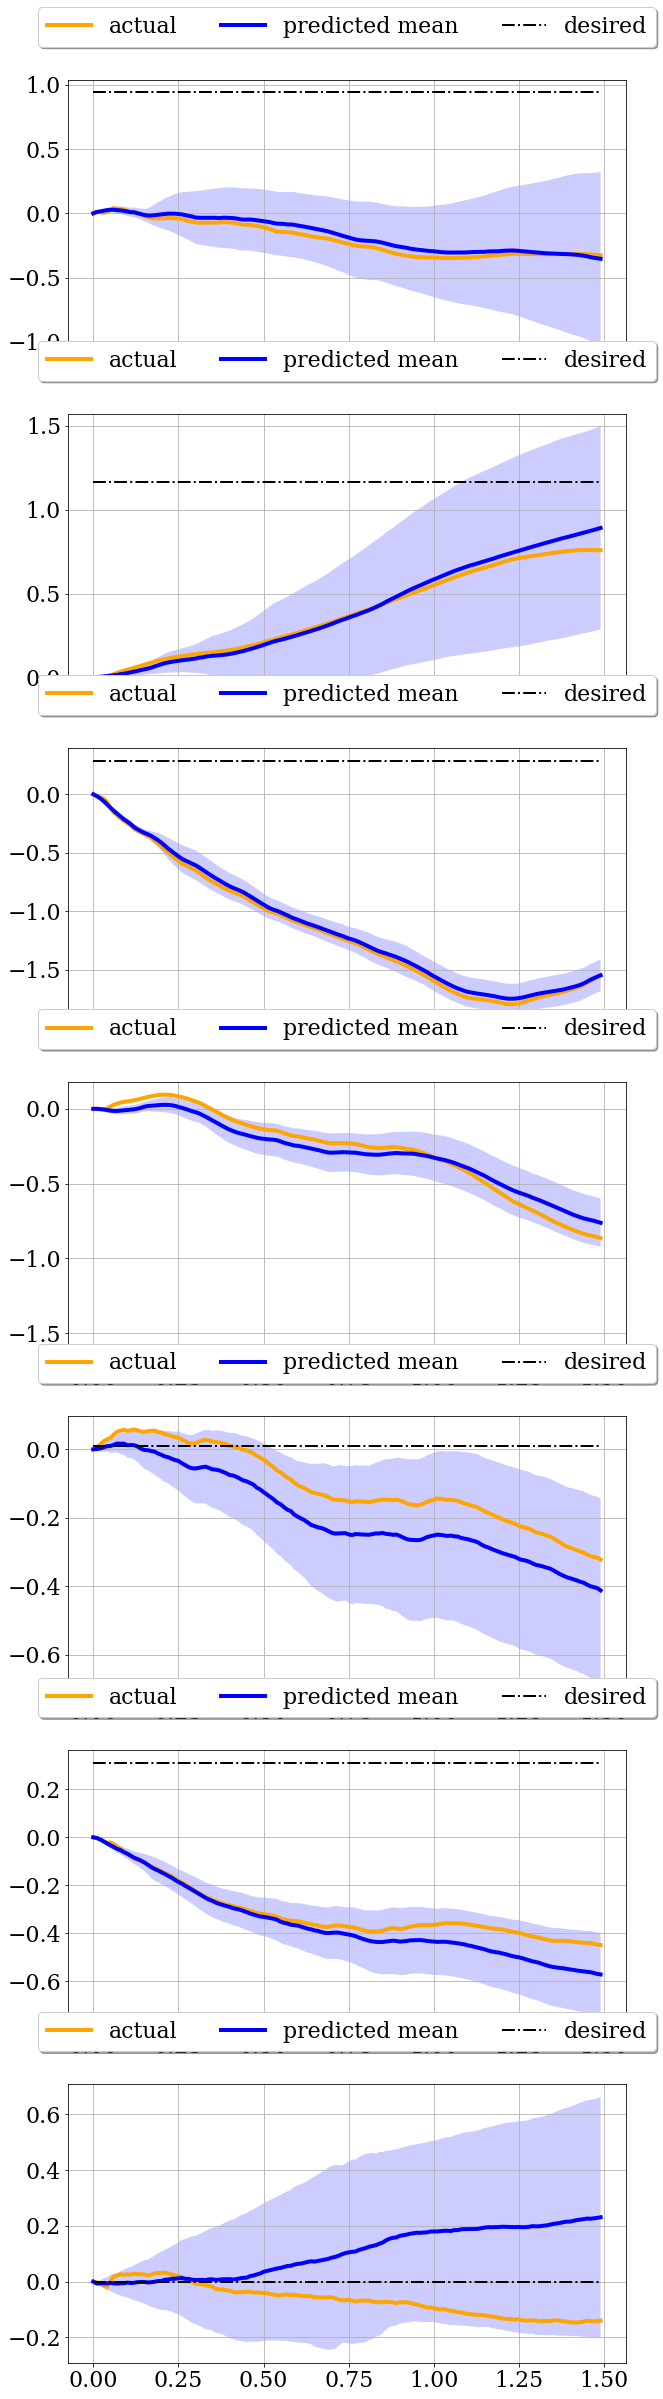

In [15]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
#     _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')

In [ ]:
import numpy as np
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()
savepath = parentdir + '/data/kuka/'


data_train = np.load(savepath+'data_pd_reg.npy')
task = KukaReaching(render=True)
task.visualize_training_data(data_train, 0)